# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
# Import packages

import warnings

import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt
import pandas as pd

import time

In [2]:
# %matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
# read output data from FZ and HI filters
#ds_pws = xr.open_dataset(
#    "C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_data_FZ_filtered_rainfall.nc"
#)
ds_pws = xr.open_dataset('C:/Users/a002461/Lund/Outputs/Bastad/four_PWS_after_QC_UTCplus2_naive_2022_xyEPSG3006.nc')

# slice to time of interest
#ds_pws = ds_pws.sel(time=slice("2017-07-01 00:00", "2017-08-01 00:00"))
ds_pws = ds_pws.sel(time = slice('2022-07-01','2022-07-30'))

In [3]:
ds_pws

<xarray.Dataset>
Dimensions:    (time: 8640, id: 4)
Coordinates:
  * time       (time) datetime64[ns] 2022-07-01 ... 2022-07-30T23:55:00
  * id         (id) <U16 'Netatmo_SE007750' ... 'Netatmo_SE001267'
    latitude   (id) float64 ...
    longitude  (id) float64 ...
    x          (id) float64 ...
    y          (id) float64 ...
Data variables:
    rainfall   (id, time) float32 ...

In [12]:
# this should be an input parameter to the function!

# strict: including only stations that passed the FZ and HI test (fz_flag == 0, hi_flag == 0)
# setting 1 and -1 to NaN
#filtered_rain = ds_pws.rainfall.where(
#    ds_pws.hi_flag != 0, np.NaN
#).to_dataset()  # this should be done for FZ flag as well!

# flex: including stations that passed the FZ and HI filters, and stations that do not have enough neighbours to apply the filters
# setting 1 to -NaN
# filtered_rain = ds_pws.rainfall.where(ds_pws.hi_flag == 1, np.NaN).to_dataset()
#filtered_rain

In [4]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

In [5]:
distance_matrix

<xarray.DataArray (id: 4, id_neighbor: 4)>
array([[   0.        ,  731.35532014, 1666.38832146, 2026.61118699],
       [ 731.35532014,    0.        , 1348.98856802, 1710.07170704],
       [1666.38832146, 1348.98856802,    0.        ,  367.8902365 ],
       [2026.61118699, 1710.07170704,  367.8902365 ,    0.        ]])
Coordinates:
  * id           (id) <U16 'Netatmo_SE007750' ... 'Netatmo_SE001267'
  * id_neighbor  (id_neighbor) <U16 'Netatmo_SE007750' ... 'Netatmo_SE001267'

# Apply SO filter

In [6]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.15
beta = 0.2
n_stat = 2
max_distance = 10e3

In [9]:
# Boolean 2D data array, defining neihbours within max_distance for all stations
#max_distance = 10e3
#neighbor_matrix = distance_matrix < max_distance

In [7]:
# Default Bias Correction Factor
dbc = 1

In [8]:
# Boolean 2D array (id, time) of true (rain > 0) or false (rain =< 0) for all stations and timesteps
#rainy_timesteps = ds_pws.fz_filtered_rain > 0

rainy_timesteps = ds_pws.rainfall > 0

In [9]:
# cumulative rainy timesteps per station
cum_rainy_timesteps = rainy_timesteps.cumsum(dim="time")

In [10]:
# initialize ugly solution
numbers = np.empty_like(ds_pws.rainfall)
numbers[:, :] = range(len(ds_pws.time))
numbers = numbers.astype(int)
ds_pws["number"] = (("id", "time"), numbers)
ds_pws

<xarray.Dataset>
Dimensions:    (time: 8640, id: 4)
Coordinates:
  * time       (time) datetime64[ns] 2022-07-01 ... 2022-07-30T23:55:00
  * id         (id) <U16 'Netatmo_SE007750' ... 'Netatmo_SE001267'
    latitude   (id) float64 ...
    longitude  (id) float64 ...
    x          (id) float64 3.677e+05 3.68e+05 3.669e+05 3.666e+05
    y          (id) float64 6.255e+06 6.256e+06 6.256e+06 6.257e+06
Data variables:
    rainfall   (id, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    number     (id, time) int32 0 1 2 3 4 5 6 ... 8634 8635 8636 8637 8638 8639

In [11]:
# initalize with empty numpy array
so_flag = np.empty_like(ds_pws.rainfall)
biascorrectiontable = np.empty_like(ds_pws.rainfall)

### Old, perhaps faster version

In [28]:
%%time

# fix the code so that it is not dependent on "filtered" rainfall
ds = ds_pws.load() 
tt = time.time()


# for i, station_id in enumerate(filtered_rain.id.data):
for i, station_id in enumerate(["ams1"]):  # enumerate(["ams1", "ams45", "ams17"]):
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc

    # THE NEIGHBOR PICKING SHOULD BE DONE EARLIER IN THE CODE! Already in FZ filter
    # picking stations within range, excluding itself

    nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
        distance_matrix.sel(id=station_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=station_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < nstat) or (
        ds_pws.rainfall.sel(id=station_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, mint + 1000)).data, start=mint
        ):
            # All entries up to mint should be filled with -1

            # fixed evaluation period
            # evaluation_period_start = timestep - mint + 1
            # evaluation_period_end = timestep

            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps
            if (
                cum_rainy_timesteps.sel(id=station_id, time=timestep)
                - cum_rainy_timesteps.sel(id=station_id).isel(time=j - mint + 1)
                >= mrain
            ):
                # print('there ARE at least mrain rainy timesteps within the last mint timesteps')
                evaluation_period_start = j - mint  # +1
                evaluation_period_end = j

            # variable evaluation period if less than mrain rainy timesteps in the last mint timesteps (but before the considered period starts)
            elif (cum_rainy_timesteps.sel(id=station_id).isel(time=j).data - mrain) > 0:
                # print('there ARE NOT at least mrain rainy timesteps within the last mint timesteps')

                start_timestamp = (
                    cum_rainy_timesteps.sel(id=station_id)
                    .where(
                        cum_rainy_timesteps.sel(id=station_id).data
                        == (
                            cum_rainy_timesteps.sel(id=station_id).isel(time=j).data
                            - mrain
                        )
                    )
                    .dropna(dim="time")
                    .time.data
                )
                start_timestamp = start_timestamp[-1]

                evaluation_period_start = int(
                    ds_pws.number.sel(id=station_id)
                    .where(
                        ds_pws.number.sel(id=station_id).time.data == start_timestamp
                    )
                    .dropna(dim="time")
                    .data.item()
                )
                evaluation_period_end = j

            else:  # assign -1 to SO filter, we are in the 'warm up period' of the filter
                # print('this wont work sorry')
                so_flag[i, j] = -1
                continue

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )

            if matches < mmatch:
                so_flag[i, timestep] = -1
                

            else:
                # suppress runtime warning
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        # pearson correlation with neighboring stations
                        corr = xr.corr(
                            ds_pws.rainfall.sel(id=station_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                        )
                        corr_values[k] = corr.data  # ???

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws.rainfall.sel(id=station_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        ) - ds_pws.rainfall.sel(id=neighbor_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        )

                        bias = np.nanmean(delta_r) / np.nanmean(
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        )
                        bias_values[k] = bias

                        # If the median of the r values falls short of threshold gamma, the SO flag is set to 1.
                        median_correlation = np.median(corr_values)

                        if median_correlation > gamma:
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCF_new = 1 / (1 + median_bias)
                            if np.abs(np.log(BCF_new / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCF_new
                                biascorrectiontable[i,j] = BCF_new

                        # if pearson correlation is too low, then it is a "station outlier"
                        else:
                            so_flag[i, j] = 1
                            biascorrectiontable[i,j] = BCF_prev

CPU times: total: 10.9 s
Wall time: 11 s


## new, perhaps slower version. NOTE! Only fixed evaluation period below!

In [12]:
np.shape(biascorrectiontable)

(4, 8640)

In [20]:
so_flag

array([[7.2059072e+19, 8.5899596e-43, 3.7910874e+33, ..., 8.9081805e-39,
        9.2755463e-39, 5.6938554e-39],
       [1.0744837e-38, 9.2755463e-39, 1.1020304e-38, ..., 8.6370000e+03,
        8.6380000e+03, 8.6390000e+03],
       [0.0000000e+00, 1.0000000e+00, 2.0000000e+00, ..., 8.6370000e+03,
        8.6380000e+03, 8.6390000e+03],
       [0.0000000e+00, 1.0000000e+00, 2.0000000e+00, ..., 8.6370000e+03,
        8.6380000e+03, 8.6390000e+03]], dtype=float32)

In [22]:
biascorrectiontable

array([[7.2059072e+19, 8.5899596e-43, 3.2032194e+33, ..., 1.0193879e-38,
        2.9388900e-39, 1.0469415e-38],
       [9.6427902e-39, 1.0193879e-38, 4.1327515e-39, ..., 9.2755463e-39,
        5.5102166e-39, 1.0561148e-38],
       [9.4592215e-39, 5.5102166e-39, 9.9182994e-39, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [21]:
bias

-0.034660503

In [13]:
%%time

ds_pws = ds_pws.load()
tt = time.time()

for i, station_id in enumerate(['Netatmo_SE007750']):  # enumerate(ds_pws.id.data): 
    print(station_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
        distance_matrix.sel(id=station_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=station_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )
    print(neighbors.data)

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=station_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, -1)).data, start=mint
        ):
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev
            
            if time.time() - tt > 30: # every now and then print some info
                tt = time.time()
                print('After 30 sec, station:', i, 'of', len(ds_pws.id), 'timestep:', j, 'of', len(ds_pws.time))
                
            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps

            evaluation_period_start = j - mint +1
            evaluation_period_end = j

            # number of rainy timesteps within evaulation period from neighbors
            
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )
            
            if matches < mmatch:
            # filter cannot be applied if less than mmatch overlapping time intvervals
                print('hej')
                so_flag[i, timestep] = -1

            else:
                # suppress runtime warning
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    
                    #t1 = time.time()
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        
                        # pearson correlation with neighboring stations
                        corr = xr.corr(
                            ds_pws.rainfall.sel(id=station_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                        )
                        corr_values[k] = corr.data  

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws.rainfall.sel(id=station_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        ) - ds_pws.rainfall.sel(id=neighbor_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        )

                        bias = np.nanmean(delta_r) / np.nanmean(
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        )
                        bias_values[k] = bias
                        
                        median_correlation = np.median(corr_values)
                        
                        # if median correlation is above threshold gamma,
                        # calculate new bias correction factor
                        if median_correlation > gamma:
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCF_new = 1 / (1 + median_bias)
                            if np.abs(np.log(BCF_new / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCF_new
                                biascorrectiontable[i,j] = BCF_new

                        # if the median of the pearson correlation with the neighbors is too low, 
                        # it is a "station outlier"
                        else:
                            so_flag[i, j] = 1
                            biascorrectiontable[i,j] = BCF_prev
                        #t2 = time.time()
                        #print(t2-t1)
                        
            #print('timestep', j, 'took', t2 - t1, 'seconds to run')
    #so_flag.to_pickle('C:/Users/a002461/OPENSENSE/data/'+station_id+'.pkl')        


Netatmo_SE007750
['Netatmo_SE010181' 'Netatmo_SE009022' 'Netatmo_SE001267']
After 30 sec, station: 0 of 4 timestep: 4390 of 8640


KeyboardInterrupt: 

In [16]:
# add flags to dataset
ds_pws["so_flag"] = (("id", "time"), so_flag)
ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [15]:
np.shape(biascorrectiontable[0,:])

(8640,)

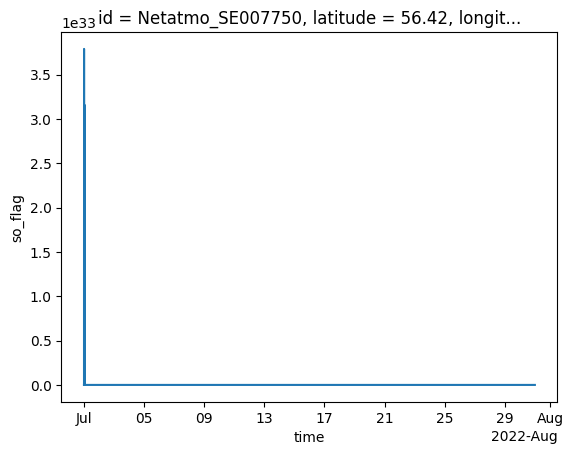

In [18]:
ds_pws.so_flag.isel(id = 0).plot()

In [19]:
ds_pws.so_flag.isel(id = 0).data

array([7.2059072e+19, 8.5899596e-43, 3.7910874e+33, ..., 8.9081805e-39,
       9.2755463e-39, 5.6938554e-39], dtype=float32)